# Notebook 4 : Arbres et méthodes ensemblistes

Notebook préparé par [Chloé-Agathe Azencott](http://cazencott.info).

Dans ce notebook il s'agit de découvrir les arbres de décision et les méthodes ensemblistes (forêts aléatoires, boosting de gradient).

In [1]:
# charger numpy as np, matplotlib as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

In [3]:
import pandas as pd

## 1. Chargement des données

Le but de ce notebook est d'utiliser la description visuelle d'un champignon pour prédire s'il est comestible ou non.

Les données sont disponibles dans `data/mushrooms.csv`. Elles sont issues du jeu de données https://archive.ics.uci.edu/ml/datasets/Mushroom mais légèrement modifiées.

Il contient une première ligne (header) décrivant les colonnes, puis une ligne par champignon. Les valeurs des différentes variables sont toutes représentées par des lettres ; en voici la signification :
1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

La première colomne nous informe de la classe de chaque champignon, 'e' pour comestible (edible) et 'p' pour vénéneux (poisonous).

In [ ]:
df = pd.read_csv('data/mushrooms.csv')
df.shape

__Alternativement :__ Si vous avez besoin de télécharger le fichier (par exemple sur colab) décommentez les deux lignes suivantes :

In [ ]:
!wget https://raw.githubusercontent.com/CBIO-mines/fml-dassault-systems/main/data/mushrooms.csv

df = pd.read_csv("mushrooms.csv")

--2026-02-01 17:08:41--  https://raw.githubusercontent.com/CBIO-mines/fml-dassault-systems/main/data/mushrooms.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374004 (365K) [text/plain]
Saving to: ‘mushrooms.csv’

mushrooms.csv       100%[===================>] 365.24K  --.-KB/s    in 0.04s   

2026-02-01 17:08:41 (10.0 MB/s) - ‘mushrooms.csv’ saved [374004/374004]



In [ ]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Conversion des variables en valeurs numériques

Nos variables sont pour l'instant _catégorielles._

Par exemple, pour la variable "forme du chapeau" (`cap shape`), `b` correspond à un chapeau campanulé (bell cap), `c` à un chapeau conique (conical cap), `f` à un chapeau plat (flat cap), `k` à un chapeau papillé (knobbed cap), `s` à un chapeau déprimé (sunken cap), and `x` à un chapeau convexe.

Pour travailler avec ces données, il nous faut convertir ces catégories en valeurs numériques.

Une possibilité est de convertir chaque lettre en un nombre entre 0 et le nombre total de catégorie, grâce à [preprocessing.LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

Cet encodage n'est pas nécessairement idéal : un algorithme qui utilise la distance euclidienne va considérer qu'un chapeau convexe (`x` converti en 5) est plus proche d'un chapeau déprimé (`s` converti en 4) que d'un chapeau conique (`c` converti en 1), ce qui n'a pas beaucoup de sens. Cela ne pose cependant pas de problème pour les algorithmes basés sur les arbres de décision, qui traitent les catégories comme telles et non pas comme des valeurs numériques. La conversion est uniquement nécessaire pour des raisons d'implémentation.

L'encodage [one-hot](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features) est généralement un meilleur choix. Remarquez néanmoins qu'il a l'inconvénient d'augmenter le nombre de variables, et de créer des variables corrélées.

In [ ]:
from sklearn import preprocessing

In [ ]:
label_encoder = preprocessing.LabelEncoder()

for col in df.columns:
    df[col] = label_encoder.fit_transform(df[col])

Nous pouvons de nouveau observer nos données :

In [ ]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


### Création des matrices X et y de données

In [ ]:
X = np.array(df.drop(columns=['class']))

In [ ]:
y = np.array(df['class'])

In [ ]:
print(X.shape, y.shape)

(8124, 22) (8124,)


__Question :__ Combien d'échantillons (examples) notre jeu de données contient-il ? Combien de variables ?

## 2. Cadre de sélection et évaluation

Nous pouvons maintenant séparer nos données en un jeu d'entrainement et un jeu de test, puis fixer une séparation du jeu d'entrainement en 10 folds pour pouvoir faire des validations croisées dessus.

In [ ]:
from sklearn import model_selection

### Jeu d'entrainement et de test

In [ ]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.3, # 30% des données dans le jeu de test
                                    random_state=42 # graine du générateur aléatoire
                                    )

### Validation croisée

In [ ]:
n_folds = 10

# Créer un objet KFold qui permettra de cross-valider en n_folds folds
kf = model_selection.KFold(n_splits=n_folds,
                           shuffle=True, # mélanger les échantillons avant de créer les folds
                           random_state=42 # graine pour le mélange des échantillons et pour la reproductibilité
                          )

# Utiliser kf pour partager le jeu d'entraînement en n_folds folds.
# kf.split retourne un iterateur (consommé après une boucle).
# Pour pouvoir se servir plusieurs fois des mêmes folds, nous transformons cet itérateur en liste d'indices :
kf_indices = list(kf.split(X_train))

In [ ]:
kf_indices

[(array([   0,    1,    2, ..., 5681, 5683, 5685]),
  array([  17,   20,   30,   39,   40,   55,   62,   66,   83,   87,   91,
           99,  107,  112,  124,  148,  160,  162,  165,  187,  191,  196,
          200,  206,  214,  216,  218,  219,  229,  237,  245,  246,  250,
          293,  296,  307,  314,  328,  337,  345,  355,  363,  365,  384,
          400,  479,  486,  490,  499,  525,  528,  535,  536,  544,  554,
          575,  576,  598,  600,  623,  636,  637,  646,  665,  677,  685,
          706,  727,  734,  735,  759,  762,  767,  800,  806,  827,  842,
          843,  848,  849,  865,  878,  879,  884,  888,  889,  898,  903,
          912,  916,  926,  930,  947,  955,  967,  974,  978, 1002, 1022,
         1042, 1057, 1074, 1081, 1082, 1101, 1109, 1110, 1111, 1116, 1145,
         1156, 1161, 1170, 1175, 1181, 1182, 1194, 1217, 1259, 1267, 1285,
         1297, 1302, 1311, 1338, 1355, 1374, 1378, 1394, 1419, 1420, 1422,
         1430, 1432, 1434, 1451, 1454, 1457, 148

## 3. Arbre de décision

Nous allons maintenant utiliser un arbre de décision pour apprendre un classifieur sur nos données.

Les arbres de décision sont implémentés dans la classe [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) du module `tree` de scikit-learn.

In [ ]:
from sklearn import tree

### Arbre de décision avec les hyperparamètres par défaut

Déterminons le score F1 en validation croisée d'un arbre de décision dont les hyperparamètres prennent les valeurs par défaut dans scikit-learn :

In [ ]:
model_tree_default = tree.DecisionTreeClassifier()

In [ ]:
f1_tree_default = model_selection.cross_val_score(model_tree_default, # prédicteur à évaluer
                                                  X_train, y_train, # données d'entrainement
                                                  cv=kf_indices, # validation croisée à utiliser
                                                  scoring='f1' # métrique d'évaluation de la performance
                                                  )

In [ ]:
print("F1 d'un abre de décision (défaut) en validation croisée : %.3f +/- %.3f" % (np.mean(f1_tree_default), np.std(f1_tree_default)))

F1 d'un abre de décision (défaut) en validation croisée : 0.873 +/- 0.010


__Question :__ Que pensez-vous de cette performance ?

### Validation croisée de la profondeur de l'arbre de décision

Par défaut (voir la doc), nous avons utilisé un arbre de décision dont la profondeur est maximale. Nous allons maintenant considérer la profondeur de l'arbre (`max_depth`) comme un hyperparamètre à optimiser par une recherche en grille. Nous reprenons et adaptons le code utilisé pour les kNN dans le Notebook 3.

Commençons par définir la grille :

In [ ]:
d_values = np.arange(2, 31)

Nous pouvons maintenant utiliser [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  :

In [ ]:
# Instanciation d'un objet GridSearchCV
grid_tree = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), # prédicteur à évaluer
                                         {'max_depth': d_values}, # dictionnaire de valeurs d'hyperparamètres
                                         cv=kf_indices, # validation croisée à utiliser
                                         scoring='f1' # métrique d'évaluation de la performance
                                         )

In [ ]:
%%time

# Utilisation de cet objet sur les données d'entraînement
grid_tree.fit(X_train, y_train)

CPU times: user 4.78 s, sys: 827 µs, total: 4.78 s
Wall time: 4.8 s


GridSearchCV(cv=[(array([   0,    1,    2, ..., 5681, 5683, 5685]),
                  array([  17,   20,   30,   39,   40,   55,   62,   66,   83,   87,   91,
         99,  107,  112,  124,  148,  160,  162,  165,  187,  191,  196,
        200,  206,  214,  216,  218,  219,  229,  237,  245,  246,  250,
        293,  296,  307,  314,  328,  337,  345,  355,  363,  365,  384,
        400,  479,  486,  490,  499,  525,  528,  535,  536,  544,  554,
        575,  576,  598,  600,  623,  636,  637,  646,  665,  677,  685,
        706,  727,  734,  735,  759,  762,  767,  800,  806,  827...
       5224, 5246, 5260, 5270, 5281, 5282, 5285, 5325, 5326, 5340, 5378,
       5383, 5387, 5394, 5395, 5398, 5406, 5419, 5441, 5454, 5457, 5465,
       5468, 5472, 5483, 5488, 5511, 5518, 5536, 5553, 5561, 5564, 5575,
       5584, 5593, 5603, 5652, 5657, 5663, 5677]))],
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             scoring='f1')

La valeur optimale de l'hyperparamètre est donnée par :

In [ ]:
print(grid_tree.best_params_)

{'max_depth': np.int64(8)}


Le code suivant permet d'afficher la performance du modèle selon la valeur de l'hyperparamètre :

Text(0.5, 1.0, 'Performance (en validation croisée) le long de la grille')

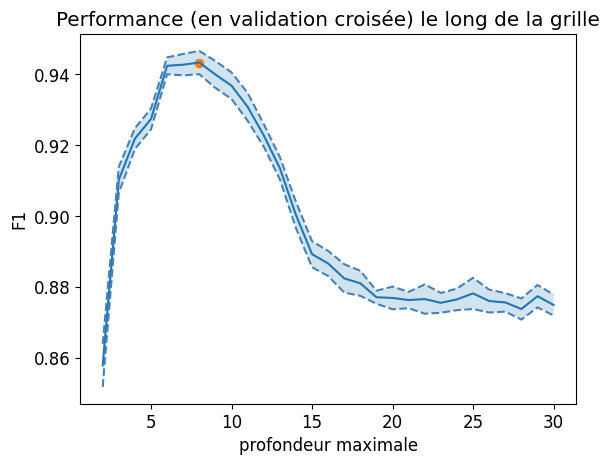

In [ ]:
mean_test_score = grid_tree.cv_results_['mean_test_score']
stde_test_score = grid_tree.cv_results_['std_test_score'] / np.sqrt(n_folds) # standard error

plt.plot(d_values, mean_test_score)
plt.plot(d_values, (mean_test_score + stde_test_score), '--', color='steelblue')
plt.plot(d_values, (mean_test_score - stde_test_score), '--', color='steelblue')
plt.fill_between(d_values, (mean_test_score + stde_test_score),
                 (mean_test_score - stde_test_score), alpha=0.2)

best_index = np.where(d_values == grid_tree.best_params_['max_depth'])[0][0]
plt.scatter(d_values[best_index], mean_test_score[best_index])


plt.xlabel('profondeur maximale')
plt.ylabel('F1')
plt.title("Performance (en validation croisée) le long de la grille")

__Question :__ Que pensez-vous de cette performance ?

### Arbre de décision optimal

In [ ]:
print("Meilleur F1 en validation croisée : %.3f" % grid_tree.best_score_)

Meilleur F1 en validation croisée : 0.943


On peut maintenant récupérer l'arbre de décision optimal :

In [ ]:
model_tree_best = grid_tree.best_estimator_

## 4. Interprétation de l'arbre de décision

### Visualisation

La méthode [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) du module `tree` de scikit-learn nous permet de visualiser l'arbre de décision optimal :

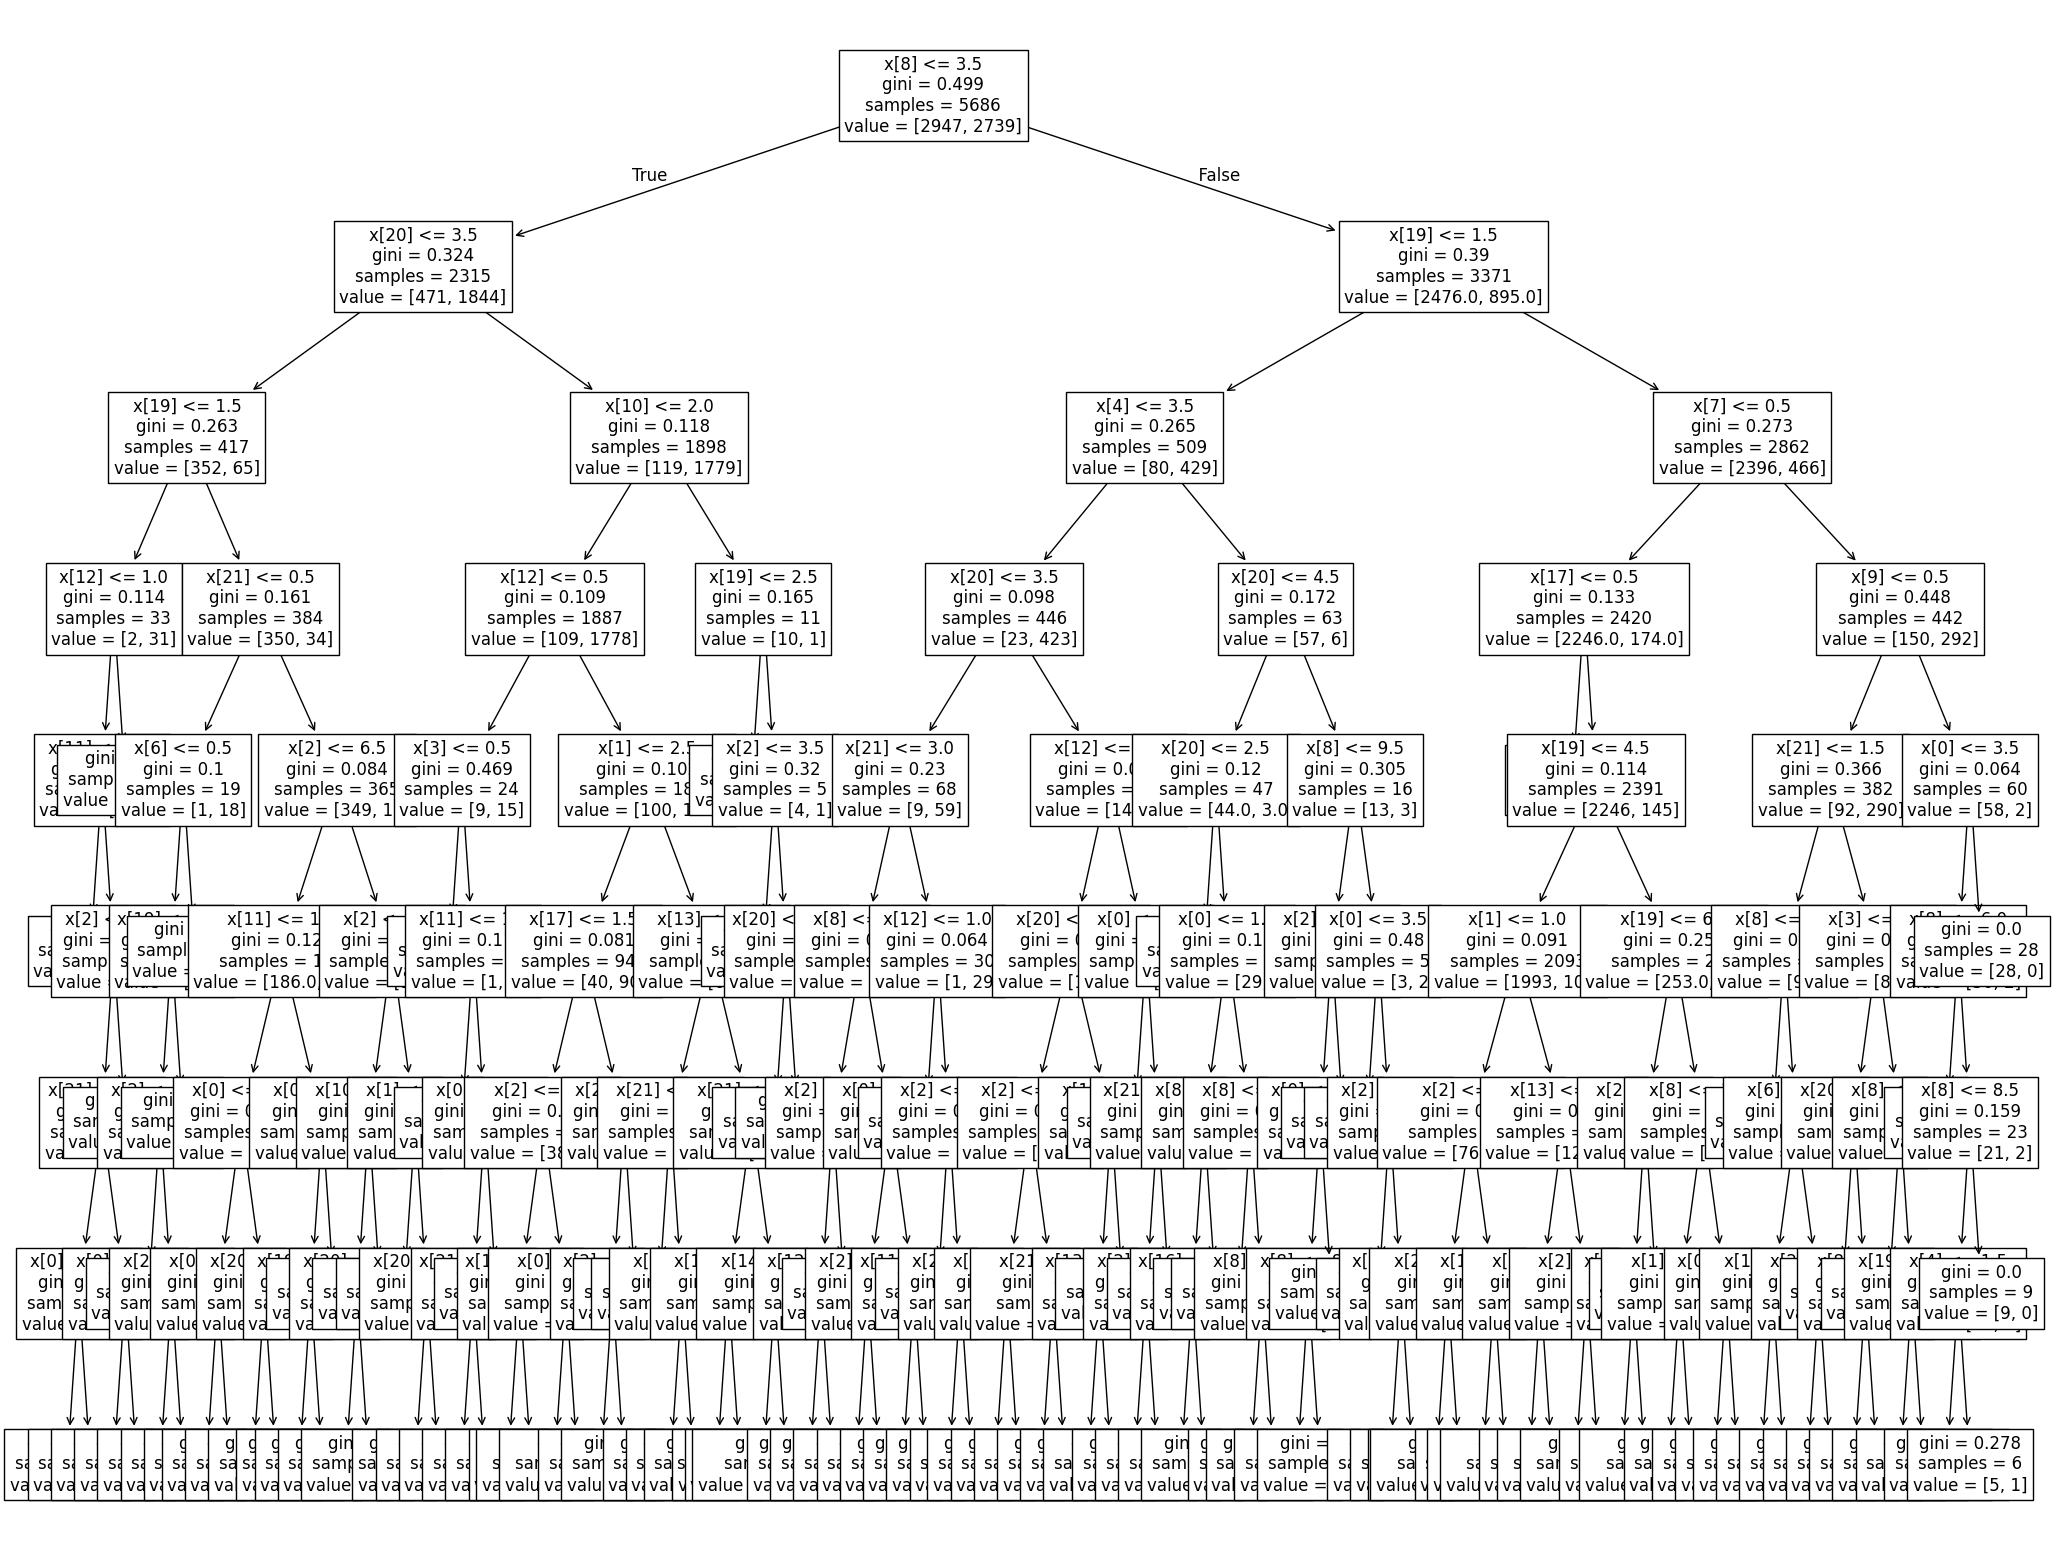

In [ ]:
fig = plt.figure(figsize=(25, 20))
tree.plot_tree(model_tree_best, fontsize=12)
plt.show()

__Question :__ Le modèle appris vous parait-il interprétable ?

### Importance des variables

Pour interpréter l'arbre de décision, nous pouvons aussi regarder l'importance de chaque variable. Elle est d'autant plus grande que la variable permet de réduire l'erreur de classification de l'arbre.

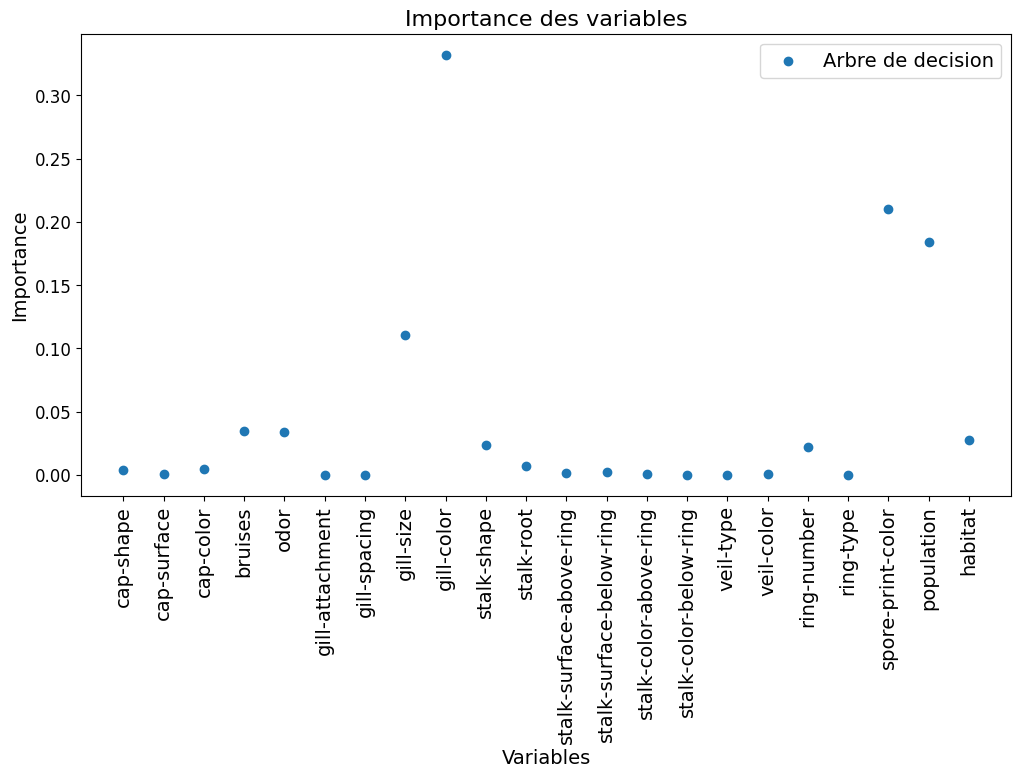

In [ ]:
fig = plt.figure(figsize=(12, 6))

num_features = X_train.shape[1]

# Afficher les importances de l'arbre de décision
plt.scatter(range(num_features), model_tree_best.feature_importances_,
           label="Arbre de decision")

# Légende
tmp = plt.legend(fontsize=14)

# Axe des abcisses
plt.xlabel('Variables', fontsize=14)
feature_names = list(df.columns[1:])
tmp = plt.xticks(range(num_features), feature_names,
                 rotation=90, fontsize=14)

# Axe des ordonnées
tmp = plt.ylabel('Importance', fontsize=14)

# Titre
tmp = plt.title('Importance des variables', fontsize=16)

### Comparaison à une régression logistique

Nous pouvons aussi comparer ces importances aux coefficients de régression d'une régression logistique :

In [ ]:
from sklearn import linear_model

In [ ]:
c_values = np.logspace(-3, 3, 50)

# Centrer-réduire les données
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Instanciation d'un objet GridSearchCV
grid_logreg = model_selection.GridSearchCV(linear_model.LogisticRegression(penalty='l2'), # prédicteur à évaluer
                                          {'C': c_values}, # dictionnaire de valeurs d'hyperparamètres
                                          cv=kf_indices, # validation croisée à utiliser
                                          scoring='f1' # métrique d'évaluation de la performance
                                          )

grid_logreg.fit(X_train_scaled, y_train)

GridSearchCV(cv=[(array([   0,    1,    2, ..., 5681, 5683, 5685]),
                  array([  17,   20,   30,   39,   40,   55,   62,   66,   83,   87,   91,
         99,  107,  112,  124,  148,  160,  162,  165,  187,  191,  196,
        200,  206,  214,  216,  218,  219,  229,  237,  245,  246,  250,
        293,  296,  307,  314,  328,  337,  345,  355,  363,  365,  384,
        400,  479,  486,  490,  499,  525,  528,  535,  536,  544,  554,
        575,  576,  598,  600,  623,  636,  637,  646,  665,  677,  685,
        706,  727,  734,  735,  759,  762,  767,  800,  806,  827...
       8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])},
             scoring='f1')

In [ ]:
print("Meilleur F1 en validation croisée : %.3f" % grid_logreg.best_score_)

Meilleur F1 en validation croisée : 0.902


__Question :__ Comparez cette performance à celle de l'arbre de décision.

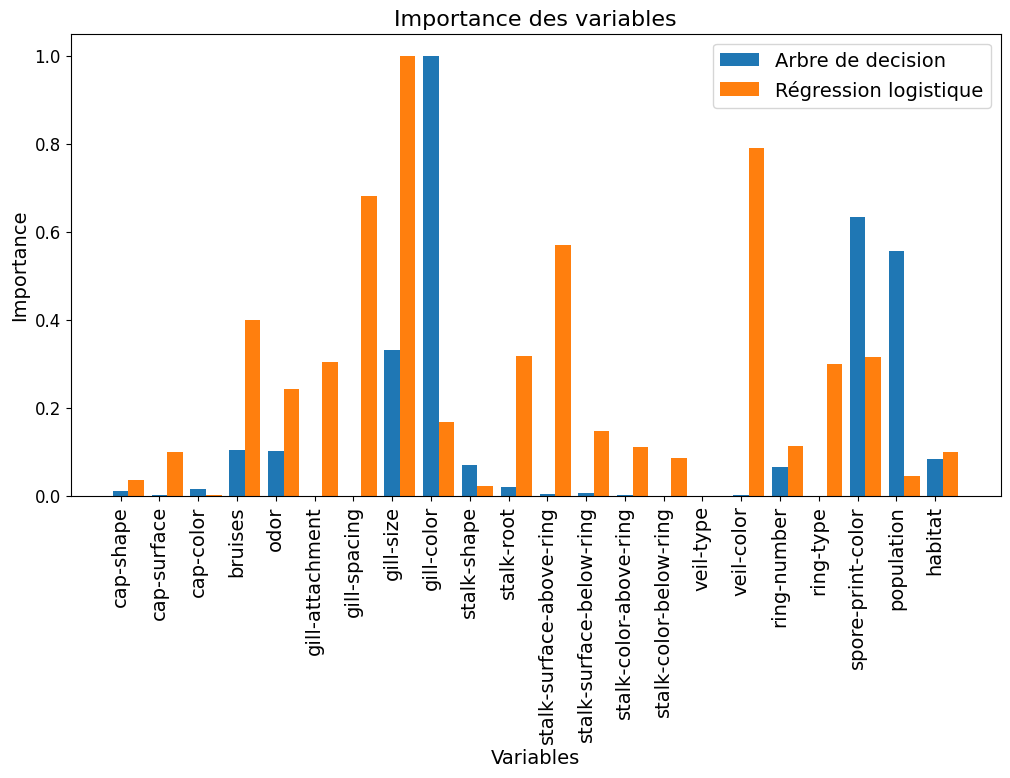

In [ ]:
fig = plt.figure(figsize=(12, 6))

num_features = X_train.shape[1]

# Ramener les importances entre 0 et 1
tree_importances = model_tree_best.feature_importances_
tree_importances_min = np.min(tree_importances)
tree_importances_max = np.max(tree_importances)
tree_importances = (tree_importances-tree_importances_min)/(tree_importances_max-tree_importances_min)

# Afficher les importances de l'arbre de décision
plt.bar(range(num_features), tree_importances,
           label="Arbre de decision", width=0.4)

# Ramener les valeurs absolues des coefficients du modèle linéaire entre 0 et 1
logreg_coeffs = np.abs(grid_logreg.best_estimator_.coef_[0])
logreg_coeffs_min = np.min(logreg_coeffs)
logreg_coeffs_max = np.max(logreg_coeffs)
logreg_coeffs = (logreg_coeffs-logreg_coeffs_min)/(logreg_coeffs_max-logreg_coeffs_min)

# Afficher les importances de la regression logistique
plt.bar((np.arange(num_features)+0.4), logreg_coeffs,
           label="Régression logistique", width=0.4)


# Légende
tmp = plt.legend(fontsize=14)

# Axe des abcisses
plt.xlabel('Variables', fontsize=14)
feature_names = list(df.columns[1:])
tmp = plt.xticks(range(num_features), feature_names,
                 rotation=90, fontsize=14)

# Axe des ordonnées
tmp = plt.ylabel('Importance', fontsize=14)

# Titre
tmp = plt.title('Importance des variables', fontsize=16)

__Question :__ Comment ces importances se comparent-elles ?

## 5. Forêt aléatoire

Peut-on améliorer les performances de l'arbre de décision en utilisant une méthode ensembliste ? Nous allons utiliser ici une forêt aléatoire, implémentée dans la classe [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) du module `ensemble` de scikit-learn.

In [ ]:
from sklearn import ensemble

### Validation croisée du nombre d'arbres et de la profondeur maximale de chacun d'entre eux.

Nous allons maintenant considérer deux hyperparamètres, la profondeur maximale de chaque arbre (`max_depth`), et le nombre d'arbres dans la forêt (`n_estimators`).

Commençons par définir la grille :

In [ ]:
d_values = np.array([3, 4, 10])
n_values = np.array([10, 20, 50, 100, 200])#, 100, 200, 500])

Nous pouvons maintenant utiliser [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  :

In [ ]:
# Instanciation d'un objet GridSearchCV
grid_rf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), # prédicteur à évaluer
                                       {'max_depth': d_values, 'n_estimators': n_values}, # dictionnaire de valeurs d'hyperparamètres
                                       cv=kf_indices, # validation croisée à utiliser
                                       scoring='f1' # métrique d'évaluation de la performance
                                       )

In [ ]:
%%time

# Utilisation de cet objet sur les données d'entraînement
grid_rf.fit(X_train, y_train)

CPU times: user 43.2 s, sys: 108 ms, total: 43.3 s
Wall time: 44 s


GridSearchCV(cv=[(array([   0,    1,    2, ..., 5681, 5683, 5685]),
                  array([  17,   20,   30,   39,   40,   55,   62,   66,   83,   87,   91,
         99,  107,  112,  124,  148,  160,  162,  165,  187,  191,  196,
        200,  206,  214,  216,  218,  219,  229,  237,  245,  246,  250,
        293,  296,  307,  314,  328,  337,  345,  355,  363,  365,  384,
        400,  479,  486,  490,  499,  525,  528,  535,  536,  544,  554,
        575,  576,  598,  600,  623,  636,  637,  646,  665,  677,  685,
        706,  727,  734,  735,  759,  762,  767,  800,  806,  827...
       5114, 5118, 5129, 5152, 5157, 5163, 5168, 5189, 5197, 5198, 5217,
       5224, 5246, 5260, 5270, 5281, 5282, 5285, 5325, 5326, 5340, 5378,
       5383, 5387, 5394, 5395, 5398, 5406, 5419, 5441, 5454, 5457, 5465,
       5468, 5472, 5483, 5488, 5511, 5518, 5536, 5553, 5561, 5564, 5575,
       5584, 5593, 5603, 5652, 5657, 5663, 5677]))],
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 3,  4, 10]),
                         'n_estimators': array([ 10,  20,  50, 100, 200])},
             scoring='f1')

La valeur optimale des hyperparamètres est donnée par :

In [ ]:
print(grid_rf.best_params_)

{'max_depth': np.int64(10), 'n_estimators': np.int64(50)}


Et nous pouvons afficher la performance du modèle selon la valeur de chacun des deux hyperparamètres :

In [ ]:
# Réorganiser les scores en tableau 2D
mean_test_score_array = np.reshape(grid_rf.cv_results_['mean_test_score'], (len(d_values), len(n_values)))
std_test_score_array = np.reshape(grid_rf.cv_results_['std_test_score'], (len(d_values), len(n_values)))

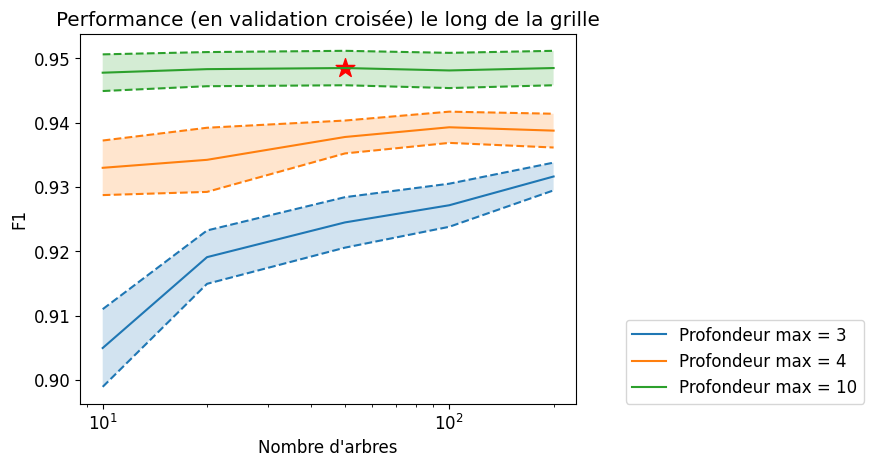

In [ ]:
for (idx, d) in enumerate(d_values):
    mean_test_score = mean_test_score_array[idx, :]
    stde_test_score = std_test_score_array[idx, :] / np.sqrt(n_folds) # standard error

    p = plt.plot(n_values, mean_test_score, label="Profondeur max = %d" % d)
    plt.plot(n_values, (mean_test_score + stde_test_score), '--', color=p[0].get_color())
    plt.plot(n_values, (mean_test_score - stde_test_score), '--', color=p[0].get_color())
    plt.fill_between(n_values, (mean_test_score + stde_test_score),
                     (mean_test_score - stde_test_score), alpha=0.2)

    # Afficher les meilleurs hyperparamètres
    if d == grid_rf.best_params_['max_depth']:
        best_ntree_index = np.where(n_values == grid_rf.best_params_['n_estimators'])[0][0]
        plt.scatter(n_values[best_ntree_index], mean_test_score[best_ntree_index],
                   marker='*', s=200, color='red')

plt.legend(loc=(1.1, 0))
plt.xlabel("Nombre d'arbres")
plt.ylabel('F1')
plt.title("Performance (en validation croisée) le long de la grille")
plt.xscale('log') # utiliser une échelle logarithmique en abcisse

__Question :__ Comment la performance des forêts aléatoires se compare-t-elle aux performances précédentes ?

### Forêt aléatoire optimale

In [ ]:
print("Meilleur F1 en validation croisée : %.3f" % grid_rf.best_score_)

Meilleur F1 en validation croisée : 0.948


On peut maintenant récupérer l'arbre de décision optimal :

In [ ]:
model_rf_best = grid_rf.best_estimator_

### Importance des variables

Nous pouvons encore une fois regarder l'importance de chaque variable, pour le meilleur modèle de forêt aléatoire :

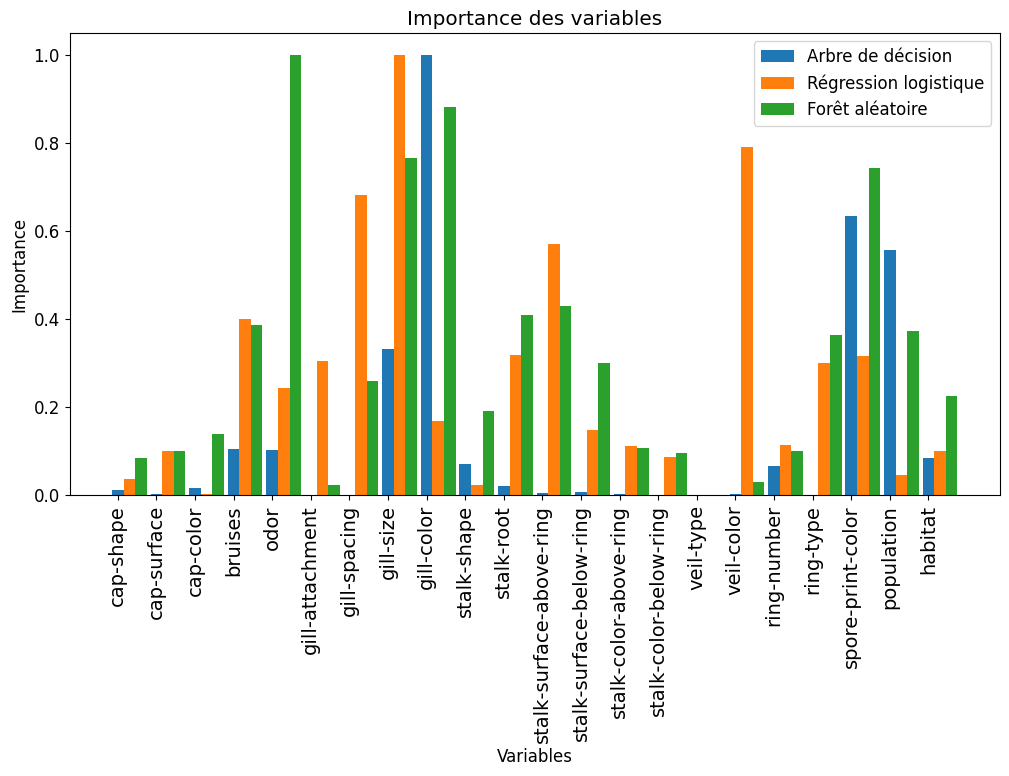

In [ ]:
fig = plt.figure(figsize=(12, 6))

num_features = X_train.shape[1]

# Ramener les importances entre 0 et 1
tree_importances = model_tree_best.feature_importances_
tree_importances_min = np.min(tree_importances)
tree_importances_max = np.max(tree_importances)
tree_importances = (tree_importances-tree_importances_min)/(tree_importances_max-tree_importances_min)

# Afficher les importances de l'arbre de décision
plt.bar(range(num_features), tree_importances,
           label="Arbre de décision", width=0.3)

# Ramener les valeurs absolues des coefficients du modèle linéaire entre 0 et 1
logreg_coeffs = np.abs(grid_logreg.best_estimator_.coef_[0])
logreg_coeffs_min = np.min(logreg_coeffs)
logreg_coeffs_max = np.max(logreg_coeffs)
logreg_coeffs = (logreg_coeffs-logreg_coeffs_min)/(logreg_coeffs_max-logreg_coeffs_min)

# Afficher les importances de la regression logistique
plt.bar((np.arange(num_features)+0.3), logreg_coeffs,
           label="Régression logistique", width=0.3)

# Ramener les importances entre 0 et 1
rf_importances = model_rf_best.feature_importances_
rf_importances_min = np.min(rf_importances)
rf_importances_max = np.max(rf_importances)
rf_importances = (rf_importances-rf_importances_min)/(rf_importances_max-rf_importances_min)

# Afficher les importances de l'arbre de décision
plt.bar((np.arange(num_features)+0.6),  rf_importances,
           label="Forêt aléatoire", width=0.3)


# Légende
tmp = plt.legend()

# Axe des abcisses
plt.xlabel('Variables')
feature_names = list(df.columns[1:])
tmp = plt.xticks(range(num_features), feature_names,
                 rotation=90, fontsize=14)

# Axe des ordonnées
tmp = plt.ylabel('Importance')

# Titre
tmp = plt.title('Importance des variables')

__Question :__ Quelles sont maintenant les variables les plus importantes ? Comment cela se compare-t-il aux modèles précédents ?

## 6. Boosting de gradient

Le boosting de gradient est implémenté dans scikit-learn dans la classe [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=boosting#sklearn.ensemble.GradientBoostingClassifier) du module `ensemble`.

### Validation croisée et sélection des hyperparamètres

Comme pour les forêts aléatoires, nous allons optimiser ici le nombre d'estimateurs et la profondeur des arbres.

In [ ]:
n_values = np.array([10, 20, 50, 100, 200])

In [ ]:
d_values = np.array([3, 4, 7])

Nous pouvons maintenant utiliser [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  :

In [ ]:
# Instanciation d'un objet GridSearchCV
grid_boost = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), # prédicteur à évaluer
                                       {'max_depth' : d_values, 'n_estimators': n_values}, # dictionnaire de valeurs d'hyperparamètres
                                       cv=kf_indices, # validation croisée à utiliser
                                       scoring='f1' # métrique d'évaluation de la performance
                                       )

In [ ]:
%%time

# Utilisation de cet objet sur les données d'entraînement
grid_boost.fit(X_train, y_train)

CPU times: user 2min 9s, sys: 147 ms, total: 2min 9s
Wall time: 2min 10s


GridSearchCV(cv=[(array([   0,    1,    2, ..., 5681, 5683, 5685]),
                  array([  17,   20,   30,   39,   40,   55,   62,   66,   83,   87,   91,
         99,  107,  112,  124,  148,  160,  162,  165,  187,  191,  196,
        200,  206,  214,  216,  218,  219,  229,  237,  245,  246,  250,
        293,  296,  307,  314,  328,  337,  345,  355,  363,  365,  384,
        400,  479,  486,  490,  499,  525,  528,  535,  536,  544,  554,
        575,  576,  598,  600,  623,  636,  637,  646,  665,  677,  685,
        706,  727,  734,  735,  759,  762,  767,  800,  806,  827...
       5114, 5118, 5129, 5152, 5157, 5163, 5168, 5189, 5197, 5198, 5217,
       5224, 5246, 5260, 5270, 5281, 5282, 5285, 5325, 5326, 5340, 5378,
       5383, 5387, 5394, 5395, 5398, 5406, 5419, 5441, 5454, 5457, 5465,
       5468, 5472, 5483, 5488, 5511, 5518, 5536, 5553, 5561, 5564, 5575,
       5584, 5593, 5603, 5652, 5657, 5663, 5677]))],
             estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': array([3, 4, 7]),
                         'n_estimators': array([ 10,  20,  50, 100, 200])},
             scoring='f1')

La valeur optimale des hyperparamètres est donnée par :

In [ ]:
print(grid_boost.best_params_)

{'max_depth': np.int64(4), 'n_estimators': np.int64(50)}


Et nous pouvons afficher la performance du modèle selon la valeur de chacun des deux hyperparamètres :

In [ ]:
# Réorganiser les scores en tableau 2D
mean_test_score_array = np.reshape(grid_boost.cv_results_['mean_test_score'], (len(d_values), len(n_values)))
std_test_score_array = np.reshape(grid_boost.cv_results_['std_test_score'], (len(d_values), len(n_values)))

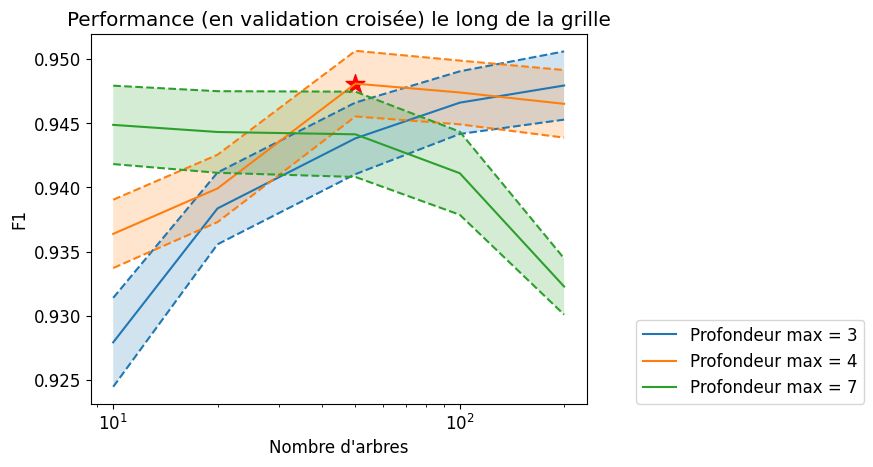

In [ ]:
for (idx, d) in enumerate(d_values):
    mean_test_score = mean_test_score_array[idx, :]
    stde_test_score = std_test_score_array[idx, :] / np.sqrt(n_folds) # standard error

    p = plt.plot(n_values, mean_test_score, label="Profondeur max = %d" % d)
    plt.plot(n_values, (mean_test_score + stde_test_score), '--', color=p[0].get_color())
    plt.plot(n_values, (mean_test_score - stde_test_score), '--', color=p[0].get_color())
    plt.fill_between(n_values, (mean_test_score + stde_test_score),
                     (mean_test_score - stde_test_score), alpha=0.2)

    # Afficher les meilleurs hyperparamètres
    if d == grid_boost.best_params_['max_depth']:
        best_ntree_index = np.where(n_values == grid_boost.best_params_['n_estimators'])[0][0]
        plt.scatter(n_values[best_ntree_index], mean_test_score[best_ntree_index],
                   marker='*', s=200, color='red')

plt.legend(loc=(1.1, 0))
plt.xlabel("Nombre d'arbres")
plt.ylabel('F1')
plt.title("Performance (en validation croisée) le long de la grille")
plt.xscale('log') # utiliser une échelle logarithmique en abcisse

__Question :__ Comment la performance du boosting de gradient évolue-t-elle en fonction des valeurd d'hyperparamètre ? Comment se compare-t-elle aux performances précédentes ?

### Boosting optimal

In [ ]:
print("Meilleur F1 en validation croisée : %.3f" % grid_boost.best_score_)

Meilleur F1 en validation croisée : 0.948


On peut maintenant récupérer l'arbre de décision optimal :

In [ ]:
model_boost_best = grid_boost.best_estimator_

### Importance des variables

Nous pouvons encore une fois regarder l'importance de chaque variable :

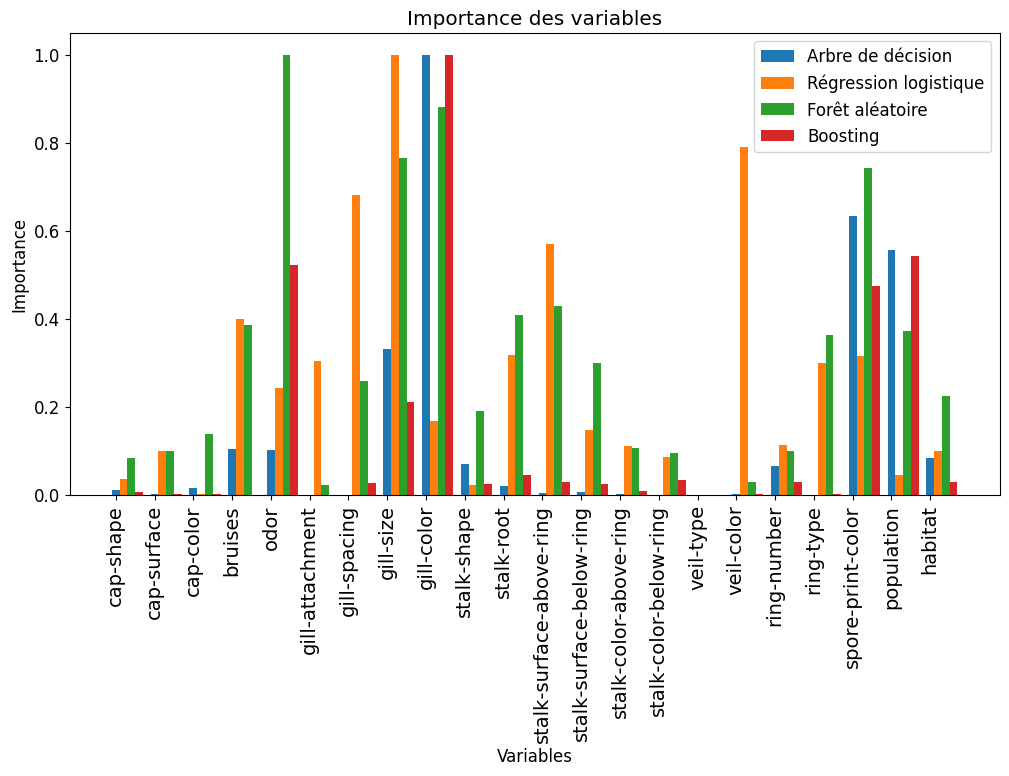

In [ ]:
fig = plt.figure(figsize=(12, 6))

num_features = X_train.shape[1]

### Arbre de décision
# Ramener les importances entre 0 et 1
tree_importances = model_tree_best.feature_importances_
tree_importances_min = np.min(tree_importances)
tree_importances_max = np.max(tree_importances)
tree_importances = (tree_importances-tree_importances_min)/(tree_importances_max-tree_importances_min)

# Afficher les importances de l'arbre de décision
plt.bar(range(num_features), tree_importances,
           label="Arbre de décision", width=0.2)

### Régression logistique
# Ramener les valeurs absolues des coefficients du modèle linéaire entre 0 et 1
logreg_coeffs = np.abs(grid_logreg.best_estimator_.coef_[0])
logreg_coeffs_min = np.min(logreg_coeffs)
logreg_coeffs_max = np.max(logreg_coeffs)
logreg_coeffs = (logreg_coeffs-logreg_coeffs_min)/(logreg_coeffs_max-logreg_coeffs_min)

# Afficher les importances de la regression logistique
plt.bar((np.arange(num_features)+0.2), logreg_coeffs,
           label="Régression logistique", width=0.2)

### Forêt aléatoire
# Ramener les importances entre 0 et 1
rf_importances = model_rf_best.feature_importances_
rf_importances_min = np.min(rf_importances)
rf_importances_max = np.max(rf_importances)
rf_importances = (rf_importances-rf_importances_min)/(rf_importances_max-rf_importances_min)

# Afficher les importances de la forêt
plt.bar((np.arange(num_features)+0.4),  rf_importances,
           label="Forêt aléatoire", width=0.2)

### Boosting
# Ramener les importances entre 0 et 1
boost_importances = model_boost_best.feature_importances_
boost_importances_min = np.min(boost_importances)
boost_importances_max = np.max(boost_importances)
boost_importances = (boost_importances-boost_importances_min)/(boost_importances_max-boost_importances_min)

# Afficher les importances du boosting
plt.bar((np.arange(num_features)+0.6),  boost_importances,
           label="Boosting", width=0.2)

# Légende
tmp = plt.legend()

# Axe des abcisses
plt.xlabel('Variables')
feature_names = list(df.columns[1:])
tmp = plt.xticks(range(num_features), feature_names,
                 rotation=90, fontsize=14)

# Axe des ordonnées
tmp = plt.ylabel('Importance')

# Titre
tmp = plt.title('Importance des variables')

__Question :__ Quelles sont maintenant les variables les plus importantes ? Comment cela se compare-t-il aux modèles précédents ?

## 7. Modèle final

__Question :__ Lequel de ces modèles choisissez vous comme le plus performant pour classifier les champignons du jeu de test ?

Vous allez maintenant évaluer le modèle que vous avez choisi sur le jeu de test :

In [ ]:
my_model = model_rf_best # TODO : insérez ici le nom du modèle que vous avez choisi.

# Prédire sur le jeu de test
y_pred = my_model.predict(X_test)

In [ ]:
from sklearn import metrics

In [ ]:
print("F1 du modèle choisir sur le jeu de test : %.3f" % metrics.f1_score(y_test, y_pred))

F1 du modèle choisir sur le jeu de test : 0.952


__Question :__ Que pensez-vous de cette performance ? Y-a-t'il un risque de surapprentissage ?

### Matrice de confusion

Pour mieux interpréter les résultats, on peut aussi visualiser la matrice de confusion :

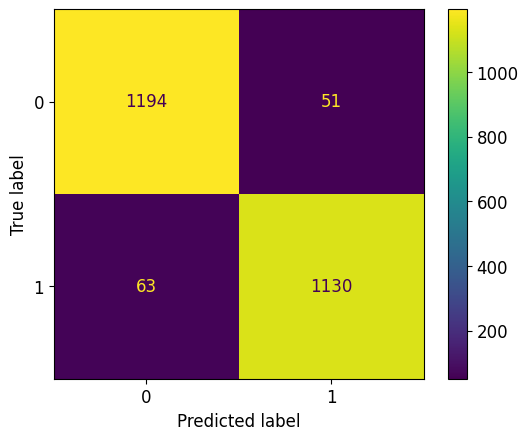

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

__Question :__ Que pensez-vous de cette matrice de confusion ? Est-elle satisfaisante ? Rappelez-vous qu'on cherche à prédire si un champignon est comestible.

### Courbe ROC

On peut aussi évaluer la performance du modèle __avant seuillage__, c'est-à-dire en utilisant les scores numériques prédits plutôt que les étiquettes binaires, grâce à une [Courbe ROC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

Les scores avant seuillage d'un modèle de classification de scikit-learn sont accessibles grâce à la méthode `predict_proba`.

In [ ]:
y_pred_scores =  my_model.predict_proba(X_test)[:, 1]
y_pred_scores

array([0.10905503, 0.98511149, 0.94843725, ..., 0.92200937, 0.02833861,
       0.03377258])

Text(0.5, 1.0, 'Courbe ROC du modèle final')

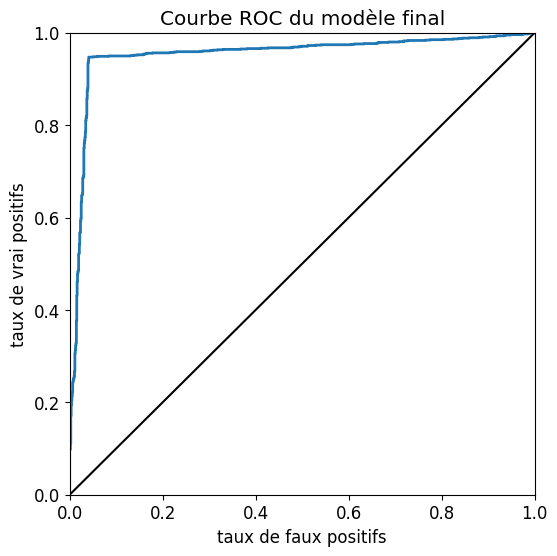

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_scores)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, lw=2)

# diagonale
plt.plot([0, 1], [0, 1], color='k')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('taux de faux positifs')
plt.ylabel('taux de vrai positifs')
plt.title("Courbe ROC du modèle final")

On peut aussi utiliser cette courbe pour déterminer le taux de vrai positifs correspondant à un taux de faux positifs donné, et déterminer le seuil correspondant :

In [ ]:
max_fpr = 0.01
max_index_where_fpr_acceptable = np.where(fpr <= max_fpr)[0][-1]
max_tpr = tpr[max_index_where_fpr_acceptable]
print("Le taux de vrais positifs correspondant à un taux de faux positifs n'excédant pas %.f %% est de %.f %%" % ((100*max_fpr), (100*max_tpr)))
print("Il correspond à un seuil de %.2f sur les prédictions du modèle." % thresholds[max_index_where_fpr_acceptable])

Le taux de vrais positifs correspondant à un taux de faux positifs n'excédant pas 1 % est de 26 %
Il correspond à un seuil de 0.97 sur les prédictions du modèle.


## Conclusion
Nous sommes arrivés à la fin de ce notebook. Voici un résumé de ce que nous avons couvert, avec les points clés :
- Nous avons utilisé la bibliothèque `scikit-learn` pour prédire si un champignon est comestible ou vénéneux à partir de ses caractéristiques visuelles.
- Nous avons essayé plusieurs modèles de classification :
    - Un arbre de décision (`DecisionTreeClassifier`)
    - Une forêt aléatoire (`RandomForestClassifier`)
    - Un boosting de gradient (`GradientBoostingClassifier`)
- Nous avons évalué la performance des modèles à l'aide du score F1 en validation croisée, qui équilibre **la précision** et **le rappel**.
- Nous avons utilisé la validation croisée et la recherche en grille (`GridSearchCV`) pour optimiser les hyperparamètres de chaque modèle (profondeur maximale, nombre d'estimateurs).
- Nous avons analysé l'interprétabilité de l'arbre de décision et comparé l'importance des variables entre les différents modèles (arbre de décision, régression logistique, forêt aléatoire, boosting).
- Nous avons observé que les méthodes ensemblistes (forêt aléatoire et boosting de gradient) ont généralement surpassé l'arbre de décision simple et la régression logistique en termes de performance F1.
- Enfin, nous avons sélectionné le meilleur modèle (Forêt aléatoire) et l'avons évalué sur le jeu de test final à l'aide du score F1, de la matrice de confusion et de la courbe ROC, pour évaluer sa généralisabilité et le risque de surapprentissage. Nous avons également discuté de l'ajustement des seuils pour équilibrer les faux positifs et les faux négatifs.